<h2>Pen Classification using Neural Networks</h2>

In [665]:
#Import the necessary libraries
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, RandomFlip, RandomRotation, RandomContrast, RandomZoom
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras import Model
import cv2
import os
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

<h3>Dataset and Data collection</h3>
<p>The Objective of this case study is to classify 2 kinds of pen namely cello pen and the Marker pens. The diffrence in their features could be the length of the pen , width or thickness of the pen, type of cap, cello pens usually have a transparent plastic body while the marker pens have a solid body , Another is the thickness of the pen tip.</p>

<p>In order to solve the problem I formed two datasets one for cello pen and one for marker pen. The dataset was manually collected from the Google Images. Another data-collection technique could be scrapping the images using BeautifulSoup/Selenium
from the official websites .Usual techniques when dataset is not available is manual collection by clicking the images under various light and surfaces which is solved by data augmentation techniques that I have used in the below section..</p>

In [625]:

#Class labels to classify the Pens
labels = ['cell', 'marker']

#Image size set.(All the Images are resized to this size which is standard.)
img_size = 224

def form_image_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                #convert BGR to RGB format
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                 # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [626]:
#I have split the train and test data in this folder format.
train = form_image_data('C:/Users/deeps/OneDrive/Desktop/navya-pics/Pens/train2')
val = form_image_data('C:/Users/deeps/OneDrive/Desktop/navya-pics/Pens/test2')



82 cello pens are there in the train dataset
63 marker pens are there in the train dataset


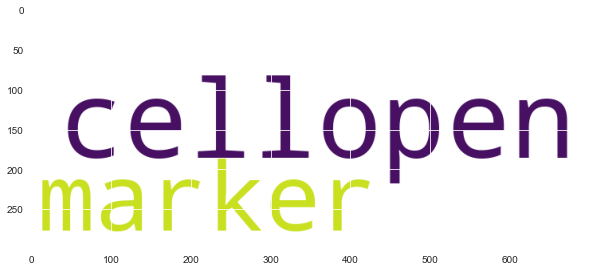

In [667]:
#Exploraray data-analysis
l = []
count_cello=0
count_marker=0
for i in train:
    if(i[1] == 0):
        l.append("cellopen")
        count_cello+=1
    else:
        l.append("marker")
        count_marker+=1

#Word cloud to show
wc = WordCloud(max_words = 3 , width = 700 , height = 300,background_color='white',
              collocations=False).generate(" ".join(l))
plt.figure(figsize = (10,10))
plt.imshow(wc)
print("\n")
print(count_cello,"cello pens are there in the train dataset")
print(count_marker,"marker pens are there in the train dataset")

<h3>Observation</h3>
<p> The dataset is slighlty imbalanced and contains more of cello pens.</p>
<p>To address this , resamplig and data augmentation techniques need to be performed for better accuracy. As there is no significant diffrence, I am not doing resampling in this case study.</p>

cell


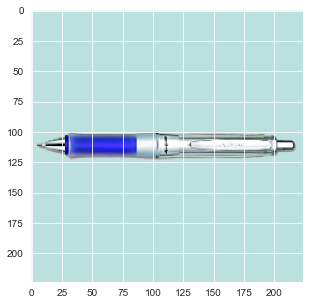

In [651]:
#Show the Cello Pen class Image
plt.figure(figsize = (5,5))
cello_pen_sample=train[2][0]
plt.imshow(cello_pen_sample)
title=labels[train[0][1]]
print(title)

marker


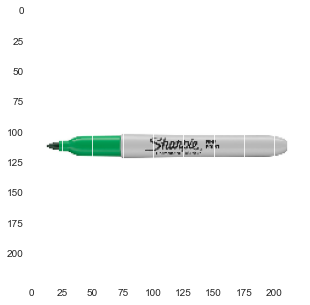

In [650]:
#Show the Marker class image 
plt.figure(figsize = (5,5))
marker_sample_image=train[-4][0]
plt.imshow(marker_sample_image)
title=labels[train[-1][1]]
print(title)

<h3>Data Augmentation</h3>
<p>This is a technique used in Image Processing and Computer Vision to increase the diversity in the training dataset on applying transformation like zooming, rotation and contrast. This helps address the problem of imbalanced dataset and also when the number of datapoints are less it helps adding more diverse dataset for training that improves the accuracy.</p>

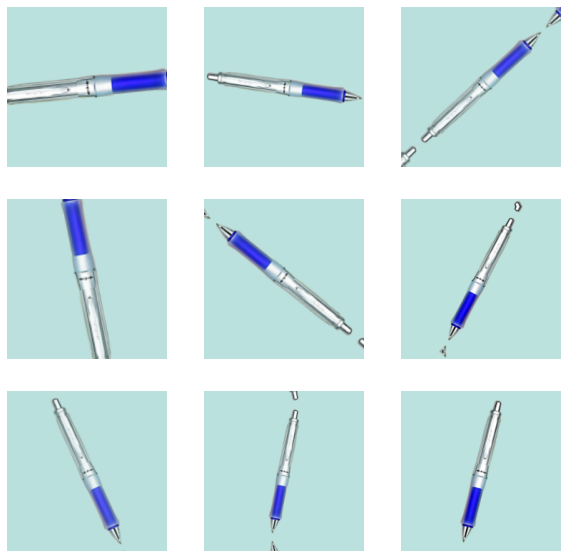

In [595]:
#1.Data Augmentation 
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5), #randomly rotates the images during training
  layers.RandomContrast(0.2),  #randomly adjusts the contract during training
  layers.RandomZoom(0.3) #randomly zooms images during training
])

#This technique is used for fabricating more data with a few dataset and it reduces the risk of overfittng.
#Show the data augmentation technique for a sample cello pen image.
image = tf.expand_dims(cello_pen_sample, 0)
plt.figure(figsize=(10, 10)) #set 10,10 dimensions
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

<h3>Observation</h3>
<p>From the above image for a sample cello pen , we can see how the trasnformations are applied to make the dataset diverse.</p>

In [596]:
#Form the train and validation sets after Normalization
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
     x_train.append(feature) #the features which is the image pixels
     y_train.append(label)  #is the labels whether a cell(0) or marker pen(1)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data to make them 1's
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

print(x_train.shape)
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
print(y_train.shape)

print(x_val.shape)
x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

#Make both x values in same shape.

(145, 224, 224, 3)
(145,)
(36, 224, 224, 3)


<h3>Convolutional Neural Networks</h3>
<p>Machines can understand Images like pixels . Pixels help to know the RGB values, edges and many aspects regarding the Images.Convolutions use this technique to identify the images and classify them. It multiples the matrix of pixels based on the kernel and then it sums them up.This is repaated for all the pixels.</p>
<p>Here the first 3 layers are Conv2D which helps deal with input Images and with varying kernel sizes say 32,32,64.Kernels are the number of nodes in each layer. These are hyper-parameters and can be tuned.Flatten layers helps to communicate between the convolution and dense layers. The final layer gives results based on 'softmax' activation function which sums up to 1 and model selects based on highest probability.</p>

In [598]:
#Define the cnn model
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3))) 
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 28, 28, 64)      

In [613]:
#Optimzer for the model and compilation of model.
opt = Adam(learning_rate=0.001) #Adam helps to control the learning arte during training during weight calculation.
epoch_data=10
#SparseCategoricalCrossentropy is generally used for classification problems.
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [614]:
#Train the model and check the accuracy on the validation set.
history = model.fit(x_train,y_train,batch_size=10,epochs = epoch_data ,verbose=1, validation_data = (x_val, y_val))

Epoch 1/10
15/15 [==============================] - 7s 417ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 1.1886 - val_accuracy: 0.8611
Epoch 2/10
15/15 [==============================] - 6s 400ms/step - loss: 0.0149 - accuracy: 0.9931 - val_loss: 2.0581 - val_accuracy: 0.8889
Epoch 3/10
15/15 [==============================] - 6s 414ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.7214 - val_accuracy: 0.8889
Epoch 4/10
15/15 [==============================] - 6s 398ms/step - loss: 0.0423 - accuracy: 0.9862 - val_loss: 2.2881 - val_accuracy: 0.8889
Epoch 5/10
15/15 [==============================] - 6s 406ms/step - loss: 0.2241 - accuracy: 0.9310 - val_loss: 0.6354 - val_accuracy: 0.8333
Epoch 6/10
15/15 [==============================] - 6s 404ms/step - loss: 0.0719 - accuracy: 0.9931 - val_loss: 0.7579 - val_accuracy: 0.8889
Epoch 7/10
15/15 [==============================] - 6s 412ms/step - loss: 0.0320 - accuracy: 0.9931 - val_loss: 0.6261 - val_accuracy: 0.8889
Epoch 

Text(0.5, 1.0, 'Training and Validation Accuracy')

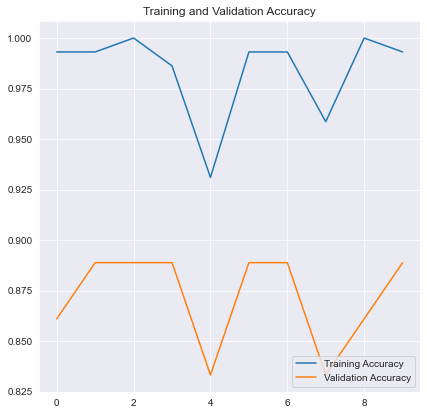

In [615]:
#Compute the Training and Validation Accuracy.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch_data)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


In [663]:
#Compute the Classification report 
print("Validation length--x :",len(x_val))
print("Validation length--y :",len(y_val))
predictions = np.argmax(model.predict(x_val),axis=-1) 
predictions = predictions.reshape(1,-1)[0]
predictions = np.round(predictions).astype(int)
print("\ny-pred:",predictions)
print("y-val :",y_val)
print("\n\t\t\tClassification report\n")
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Cell(Class 0)','Marker(Class 1)']))

Validation length--x : 36
Validation length--y : 36

y-pred: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
y-val : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

			Classification report

                 precision    recall  f1-score   support

  Cell(Class 0)       0.90      0.95      0.92        19
Marker(Class 1)       0.94      0.88      0.91        17

       accuracy                           0.92        36
      macro avg       0.92      0.91      0.92        36
   weighted avg       0.92      0.92      0.92        36



<h3>Observation:</h3>
<p>Here  we can see that without data augmentation the dataset is giving accuracy greater than 90%. This may be due to validation set having data points which may be present in the training dataset.We can further increase the accuracy by adding more data points to training data set and keeping the test data set unique.</p>

## Evaluate the misclassified images

In [676]:
mis_classified_images = x_val[predictions!=y_val]
y_true = y_val[predictions!=y_val]
y_pred = predictions[predictions!=y_val]

************************************************************
************************************************************
Actual class label:  cellopen

Predicted class label:  marker



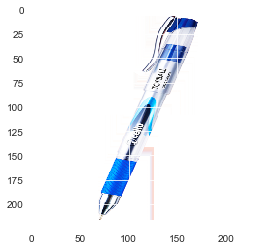

************************************************************
************************************************************
Actual class label:  marker

Predicted class label:  cellopen



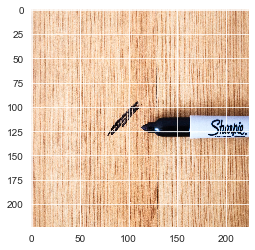

************************************************************
************************************************************
Actual class label:  marker

Predicted class label:  cellopen



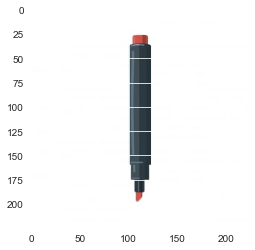

In [683]:
for i,image in enumerate(mis_classified_images):
    print("***"*20)
    print("***"*20)
    class_label_true=""
    if(y_true[i]==0):
        class_label_true="cellopen"
    else:
        class_label_true="marker"
    if(y_pred[i]==0):
        class_label="cellopen"
    else:
        class_label="marker"    

    print("Actual class label: ", class_label_true)
    print()
    print("Predicted class label: ",class_label)
    print()
    plt.imshow(image, interpolation='nearest')
    plt.show()

## Neural Network with inclusion of Data Augmentation

In [617]:
#Preprocessing the raining dataset.
train_ds = data_augmentation(x_train)

In [621]:
opt = Adam(learning_rate=0.0001)
epoch_data=15
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [622]:
new_x_train = np.vstack((x_train,train_ds))
new_y_train=np.vstack((y_train.reshape(-1,1),y_train.reshape(-1,1)))

In [623]:
history = model.fit(new_x_train,new_y_train,batch_size=10,epochs = epoch_data ,verbose=1, validation_data = (x_val, y_val))

Epoch 1/15
29/29 [==============================] - 13s 448ms/step - loss: 1.2482 - accuracy: 0.8138 - val_loss: 0.5011 - val_accuracy: 0.8611
Epoch 2/15
29/29 [==============================] - 13s 446ms/step - loss: 0.6222 - accuracy: 0.8552 - val_loss: 0.3664 - val_accuracy: 0.9444
Epoch 3/15
29/29 [==============================] - 13s 439ms/step - loss: 0.5254 - accuracy: 0.8552 - val_loss: 0.3213 - val_accuracy: 0.9444
Epoch 4/15
29/29 [==============================] - 13s 435ms/step - loss: 0.3632 - accuracy: 0.8724 - val_loss: 0.2963 - val_accuracy: 0.9444
Epoch 5/15
29/29 [==============================] - 13s 446ms/step - loss: 0.3106 - accuracy: 0.8862 - val_loss: 0.2926 - val_accuracy: 0.9444
Epoch 6/15
29/29 [==============================] - 13s 441ms/step - loss: 0.2806 - accuracy: 0.8931 - val_loss: 0.2808 - val_accuracy: 0.9444
Epoch 7/15
29/29 [==============================] - 13s 446ms/step - loss: 0.2618 - accuracy: 0.9069 - val_loss: 0.2784 - val_accuracy: 0.9444

<h3>Observation:</h3>
<p>With Data augmentation the accuracy quite high , accuracy inproved with data augmentation when compared to using just the neural network. It attained a accuracy of 94.6%. </p>

<h3>Future Work for Modelling</h3>
<p>1.Based on the misclassification analysis performed above,we can see that few data points like pen where classified as marker due to thickness in body size . Further we can collect more data points with pend having a thick body to improve the accuracy.</p>
<p>2.VGG16 which is a pre-trained model can be used along with data augmentation that can increase the accuracy further.</p>

<h3>Future Work for Data Collection</h3>
<p>1. To fetch more data points we can use beautifulsoup and Selenium frameworks and scrape the data.</p>